In [20]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [2]:
original_model = 'original'
trained_model = 'model_12'

original_df = pd.read_json('../logs/'+original_model+'/score.log', lines=True)
trained_df = pd.read_json('../logs/'+trained_model+'/score.log', lines=True)
original_fixed_df = pd.read_json('../logs/'+original_model+'/score_fixed.log', lines=True)
trained_fixed_df = pd.read_json('../logs/'+trained_model+'/score_fixed.log', lines=True)

size = min(len(trained_df), len(original_df))
fixed_size = min(len(trained_fixed_df), len(original_fixed_df))
original_df = original_df.head(size)
trained_df = trained_df.head(size)
original_fixed_df = original_fixed_df.head(fixed_size)
trained_fixed_df = trained_fixed_df.head(fixed_size)

# df['error_type'] = df['result'].apply(lambda x: x['error_type'])
# df['error'] = df['result'].apply(lambda x: x['error'])
# df['coverage'] = df['result'].apply(lambda x: x['coverage'])
# df['root_passed'] = df['result'].apply(lambda x: x['test_results']['root_passed'])
# df['root_failed'] = df['result'].apply(lambda x: x['test_results']['root_failed'])
# df['passed'] = df['result'].apply(lambda x: x['test_results']['passed'])
# df['failed'] = df['result'].apply(lambda x: x['test_results']['failed'])
# df['all_passed'] = df['result'].apply(lambda x: x['test_results']['all_passed'])

print('size', size)
print('fixed size', fixed_size)

for _, row in trained_fixed_df.head(1).iterrows():
    #print(row['completion'])
    print(row)
    print(type(row['result']), row['result'])

size 1000
fixed size 1000
hash                   3536598be3a14280f98fff5ab07e535dc21274d6166717...
project_path                   07be54bc22cf4dd2dd16a9788d2fc88952c438ae/
relative_go_package                                              wallet/
func_name                                             NewRecoveryManager
input_code             package wallet\n\nimport (\n\t"github.com/btcs...
prompt                 [{'content': '
You are an expert programmer. 
...
generate_time                                                  16.271075
completion             Here are some unit tests for the `NewRecoveryM...
score_time                                                     14.269766
result                 {'error': 'go mod tidy: code 1, 'strderr' go: ...
reward                                                               0.0
try_fix                                                             True
generate_time2                                                 26.612879
completion2            Th

/var/folders/p_/np8py4lx50v3pwpf00g66f0c0000gn/T/ipykernel_5065/1047003289.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/p_/np8py4lx50v3pwpf00g66f0c0000gn/T/ipykernel_5065/1047003289.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/p_/np8py4lx50v3pwpf00g66f0c0000gn/T/ipykernel_5065/1047003289.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


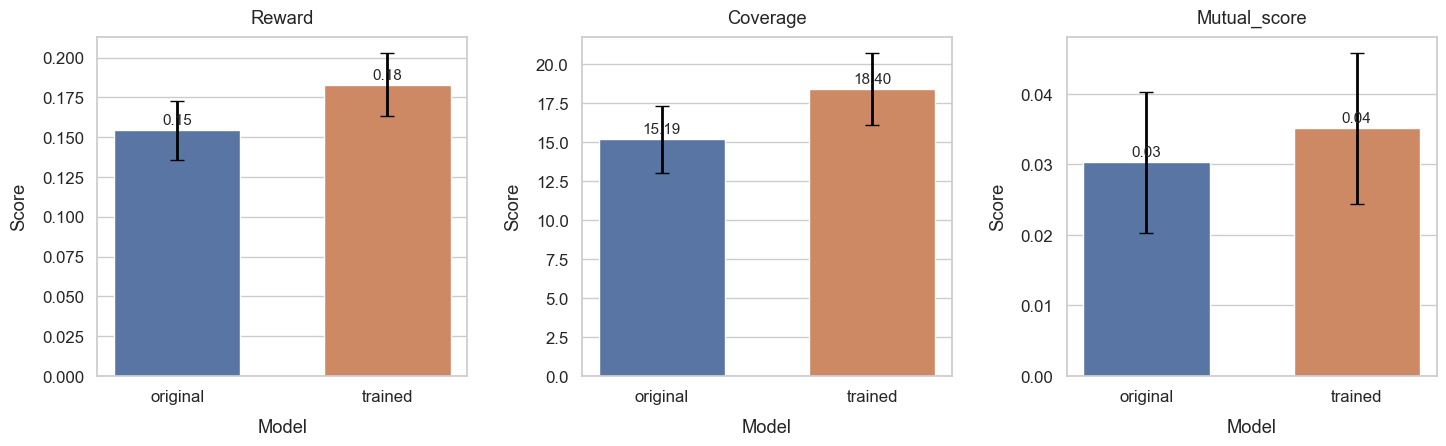

/var/folders/p_/np8py4lx50v3pwpf00g66f0c0000gn/T/ipykernel_5065/1047003289.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/p_/np8py4lx50v3pwpf00g66f0c0000gn/T/ipykernel_5065/1047003289.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/p_/np8py4lx50v3pwpf00g66f0c0000gn/T/ipykernel_5065/1047003289.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


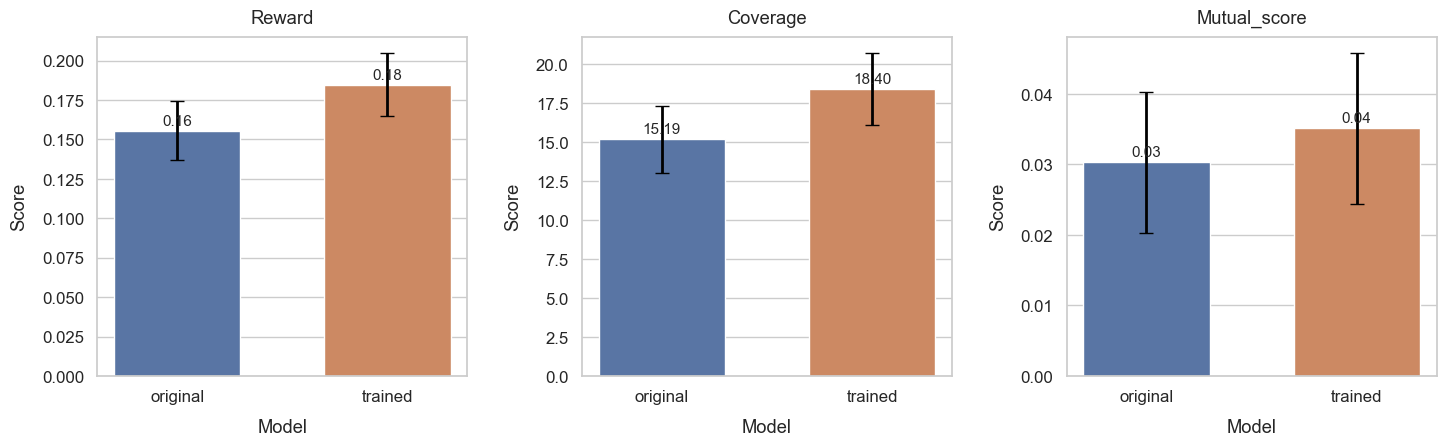

type,no fixing iteration,with fixing iteration
count,1000,1000
original reward,0.154 ±0.018,0.156 ±0.019
trained reward,0.183 ±0.020,0.185 ±0.020
trained/original,1.184 ±0.191,1.187 ±0.190
"reward uplift, %",18.4 ±19.1,18.7 ±19.0
original coverage,15.193 ±2.135,15.193 ±2.135
trained coverage,18.403 ±2.309,18.403 ±2.309
trained/original coverage,1.211 ±0.228,1.211 ±0.228
"coverage uplift, %",21.1 ±22.8,21.1 ±22.8
original no error coverage,81.255 ±4.541,81.255 ±4.541


In [ ]:
def calculate_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_err = stats.sem(data)
    ci = stats.t.interval(confidence, len(data)-1, loc=mean, scale=std_err)
    return ci

def calculate_confidence_mid_delta(data, confidence=0.95):
    l, r = calculate_confidence_interval(data, confidence)
    mid = (l+r)/2
    delta = (r-l)/2
    return mid, delta

def format_mid(mid: float, plus_minus: float, precision: int = 3) -> str:
    return f"{mid:.{precision}f} ±{plus_minus:.{precision}f}"

def format_series_mid(s: tuple[float, float], precision: int = 3) -> str:
    interval = calculate_confidence_interval(s)
    mid = (interval[0]+interval[1])/2
    plus_minus = (interval[1]-interval[0])/2
    return format_mid(mid, plus_minus, precision)

def relation_interval(X, Y) -> tuple[float, float]:    
    n_Y, n_X = len(Y), len(X)
    Y_bar, X_bar = np.mean(Y), np.mean(X)
    theta_hat = Y_bar / X_bar

    # Дисперсии
    sY2 = np.var(Y, ddof=1)  # ddof=1 для несмещённой оценки
    sX2 = np.var(X, ddof=1)

    # Дисперсия theta_hat
    var_theta = (theta_hat**2) * (sY2 / (n_Y * Y_bar**2) + sX2 / (n_X * X_bar**2))

    # 95% ДИ
    z = stats.norm.ppf(0.975)

    return theta_hat, z * np.sqrt(var_theta)

def format_interval_relation(X: tuple[float, float], Y: tuple[float, float], precision: int = 3) -> str:
    mid, plus_minus = relation_interval(X, Y)

    return format_mid(mid, plus_minus, precision)

def format_uplift(X: tuple[float, float], Y: tuple[float, float], precision: int = 1) -> str:
    mid, plus_minus = relation_interval(X, Y)

    return format_mid((mid-1)*100, plus_minus*100, precision)

def barplot(reward1, reward2, coverage1, coverage2, mutual_score1, mutual_score2):
    reward_mid1, reward_delta1 = calculate_confidence_mid_delta(reward1)
    reward_mid2, reward_delta2 = calculate_confidence_mid_delta(reward2)
    coverage_mid1, coverage_delta1 = calculate_confidence_mid_delta(coverage1)
    coverage_mid2, coverage_delta2 = calculate_confidence_mid_delta(coverage2)
    mutual_score_mid1, mutual_score_delta1 = calculate_confidence_mid_delta(mutual_score1)
    mutual_score_mid2, mutual_score_delta2 = calculate_confidence_mid_delta(mutual_score2)

    # Пример данных с доверительными интервалами (замените на ваши)
    data = {
        'model': ['original', 'trained'] * 3,
        'metric': ['reward'] * 2 + ['coverage'] * 2 + ['mutual_score'] * 2,
        'value': [reward_mid1, reward_mid2, coverage_mid1, coverage_mid2, mutual_score_mid1, mutual_score_mid2],  # Средние значения
        'ci_low': [reward_mid1-reward_delta1, reward_mid2-reward_delta2, coverage_mid1-coverage_delta1, coverage_mid2-coverage_delta2, mutual_score_mid1-mutual_score_delta1, mutual_score_mid2-mutual_score_delta2],  # Нижняя граница ДИ
        'ci_high': [reward_mid1+reward_delta1, reward_mid2+reward_delta2, coverage_mid1+coverage_delta1, coverage_mid2+coverage_delta2, mutual_score_mid1+mutual_score_delta1, mutual_score_mid2+mutual_score_delta2]  # Верхняя граница ДИ
    }
    df = pd.DataFrame(data)

    # Настройка стиля
    sns.set_theme(style="whitegrid", font_scale=1.1)
    plt.figure(figsize=(15, 5))  # Широкий график для трёх метрик

    # Создаём 3 сабплога в один ряд
    for i, metric in enumerate(['reward', 'coverage', 'mutual_score'], 1):
        plt.subplot(1, 3, i)
        
        # Фильтруем данные для текущей метрики
        subset = df[df['metric'] == metric]
        
        # Барплот с кастомизацией
        ax = sns.barplot(
            x='model',
            y='value',
            data=subset,
            palette=['#4C72B0', '#DD8452'],  # Приятные цвета
            width=0.6,  # Ширина баров
            capsize=0.1  # Шляпки на доверительных интервалах
        )
        
        # Добавляем доверительные интервалы вручную
        for j, (_, row) in enumerate(subset.iterrows()):
            ax.errorbar(
                x=j,
                y=row['value'],
                yerr=[[row['value'] - row['ci_low']], [row['ci_high'] - row['value']]],
                fmt='none',
                color='black',
                capsize=5,
                linewidth=2
            )
        
        # Настройки оформления
        plt.title(metric.capitalize(), pad=10)
        plt.ylabel('Score', labelpad=10)
        plt.xlabel('Model', labelpad=10)
        #plt.ylim(0, 1.05)  # Оставляем место сверху
        
        # Добавляем значения над барами
        for p in ax.patches:
            ax.annotate(
                f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 7),
                textcoords='offset points',
                fontsize=11
            )

    plt.tight_layout(pad=2.0)  # Убираем наложения
    plt.show()

def metrics(df1: pd.DataFrame, df2: pd.DataFrame, name: str):
    scores = []
    for df in [df1, df2]:
        df = df.copy()
        df['reward'] = df.apply(lambda x: float(x.get('best_reward', x.get('reward', None))), axis=1)
        df['coverage'] = df['result'].apply(lambda x: float(x['coverage']))
        df['mutation_score'] = df['result'].apply(lambda x: float(x['mutation_score']))
        df['error_type'] = df['result'].apply(lambda x: str(x['error_type']))
        df['all_passed'] = df['result'].apply(lambda x: int(x['test_results']['all_passed']))
        df['is_error'] = df['error_type'] != ''

        #reward = df['reward'].mean()
        reward = df['reward']
        coverage = df['coverage']
        mutation_score = df['mutation_score']
        coverage_no_error = df.query('is_error == False')['coverage']
        # mutation_score_all_success = df.query('is_error == False')['mutation_score'].mean()
        mutation_score_all_success = df.query('all_passed == 1')['mutation_score']
        all_passed = len(df.query('all_passed == 1')) / len(df) * 100.0
        scores.append((reward, coverage, mutation_score, coverage_no_error, mutation_score_all_success, all_passed))

        


    reward1, coverage1, mutation_score1, coverage_no_error1, mutation_score_all_success1, all_passed1 = scores[0]
    reward2, coverage2, mutation_score2, coverage_no_error2, mutation_score_all_success2, all_passed2 = scores[1]

    barplot(reward1, reward2, coverage1, coverage2, mutation_score1, mutation_score2)

    return {
        'type': name,
        'count': len(df1),
        'original reward': format_series_mid(reward1),
        'trained reward': format_series_mid(reward2),
        'trained/original': format_interval_relation(reward1, reward2),
        'reward uplift, %': format_uplift(reward1, reward2),

        'original coverage': format_series_mid(coverage1),
        'trained coverage': format_series_mid(coverage2),
        'trained/original coverage': format_interval_relation(coverage1, coverage2),
        'coverage uplift, %': format_uplift(coverage1, coverage2),

        'original no error coverage': format_series_mid(coverage_no_error1),
        'trained no error coverage': format_series_mid(coverage_no_error2),
        'trained/original no error coverage': format_interval_relation(coverage_no_error1, coverage_no_error2),
        'coverage no error uplift, %': format_uplift(coverage_no_error1, coverage_no_error2),

        'original mutual': format_series_mid(mutation_score1),
        'trained mutual': format_series_mid(mutation_score2),
        'trained/original mutual': format_interval_relation(mutation_score1, mutation_score2),
        'mutual uplift, %': format_uplift(mutation_score1, mutation_score2),

        'original all passed mutual': format_series_mid(mutation_score_all_success1),
        'trained all passed mutual': format_series_mid(mutation_score_all_success2),
        'trained/original all passed mutual': format_interval_relation(mutation_score_all_success1, mutation_score_all_success2),
        'mutual all passed uplift, %': format_uplift(mutation_score_all_success1, mutation_score_all_success2),

        'original all passed': '%.4f' % all_passed1,
        'trained all passed': '%.4f' % all_passed2,
        'trained/original all passed': '%.4f' % (all_passed2/all_passed1),
        'all passed uplift, %': '%.2f' % (all_passed2/all_passed1*100 - 100),
    }

report = [
    metrics(original_df, trained_df, 'no fixing iteration'),
    metrics(original_fixed_df, trained_fixed_df, 'with fixing iteration'),
]

report_df = pd.DataFrame(data=report).set_index('type').transpose()

report_df.to_markdown('../logs/report.md')
report_df.to_excel('../logs/report.xlsx')

report_df

In [ ]:
df = original_df.take(500)

df['coverage'] = df['result'].apply(lambda x: float(x['coverage']))
df['mutation_score'] = df['result'].apply(lambda x: float(x['mutation_score']))
df['error_type'] = df['result'].apply(lambda x: str(x['error_type']))
df['all_passed'] = df['result'].apply(lambda x: int(x['test_results']['all_passed']))
df['is_error'] = df['error_type'] != ''

In [ ]:
print('error count', len(df.query('is_error')))

df.query('is_error')['error_type'].value_counts()

In [ ]:
print('reward', df['reward'].mean())
print('no_error', len(df.query('is_error == False')))
print('coverage', df.query('is_error == False')['coverage'].mean())
print('mutation_score', df.query('all_passed == 1')['mutation_score'].mean())
print('all_passed_count', len(df.query('all_passed == 1')['mutation_score']))